# SMO algorithm
Here is the [link](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) to the paper

# Getting data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pandas import read_csv
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import os

In [2]:
def read_data(filename):
    a = read_csv('../data/' + filename)
    return a[['x', 'y']].values.tolist(), [1 if c == 'P' else -1 for c in a['class']]

# Hyperparameter optimization

In [3]:
def get_accuracy_score(y_true, y_predicted):
    return sum(1 if y_true_i == y_predicted_i else 0 for y_true_i, y_predicted_i in zip(y_true, y_predicted)) / len(y_true)

In [4]:
import sys
sys.path.append('../../../cf')
from svm_E import SVMClassifier 

In [5]:
def get_hyperparameters(X, y):
    k = 5
    kf = KFold(n_splits=k, shuffle=True)
    kernels = ['linear', 'polynomial', 'gaussian']
    kernel_to_param = {'linear': [None],
               'polynomial': [2, 3, 4, 5],
               'gaussian': [1, 2, 3, 4, 5]}
    best_classifier_for_kernel = {'linear': None, 'polynomial': None, 'gaussian': None}
    
    for C in tqdm([0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        for kernel in kernels:
            for parameter in kernel_to_param[kernel]:
                y_true, y_predicted = [], []
                classifier = SVMClassifier(C, kernel, parameter)
                for train_indices, test_indices in kf.split(X):
                    X_train = [X[i]  for i in range(len(X)) if i in train_indices]
                    X_test = [X[i]  for i in range(len(X)) if i in test_indices]
                    y_train = [y[i]  for i in range(len(X)) if i in train_indices]
                    y_test = [y[i]  for i in range(len(X)) if i in test_indices]
                    classifier.fit(X_train, y_train, 100)
                    y_true += y_test
                    for X_test_i in X_test:
                        y_predicted += [classifier.predict(X_test_i)]
                accuracy_score = get_accuracy_score(y_true, y_predicted)
                if best_classifier_for_kernel[kernel] is None or best_classifier_for_kernel[kernel][0] < accuracy_score:
                    best_classifier_for_kernel[kernel] = [accuracy_score, classifier]
    return best_classifier_for_kernel

# Plotting

In [6]:
def get_colors(v):
    return ['g' if y == 1 else 'r' for y in v]

def draw_graphics(X, y, classifier, kernel):
    classifier.fit(X, y)
    
    print('kernel =', kernel)
    if kernel != 'linear':
        print('parameter =', classifier.kernel_param)
    print('C =', classifier.C)
    
    plt.scatter([x[0] for x in X], [x[1] for x in X], c=get_colors(y), s=20)
    
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    points_count = 100
    background_X_x, background_X_y = np.meshgrid(
        np.linspace(xlim[0], xlim[1], points_count),
        np.linspace(ylim[0], ylim[1], points_count))
    
    background_Y = [classifier.predict([xx, xy]) for xx, xy in zip(background_X_x.ravel(), background_X_y.ravel())]
    plt.scatter(background_X_x, background_X_y, c=get_colors(background_Y), s=1, alpha=0.4)
    plt.show()


# Datasets


Best accuracy score for chips.csv is 0.5169491525423728
kernel = linear
C = 10.0


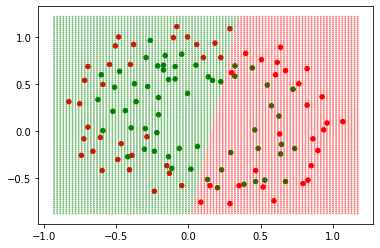

Best accuracy score for chips.csv is 0.8305084745762712
kernel = polynomial
parameter = 3
C = 5.0


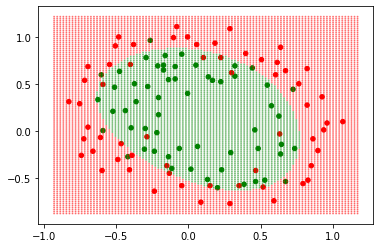

Best accuracy score for chips.csv is 0.847457627118644
kernel = gaussian
parameter = 2
C = 50.0


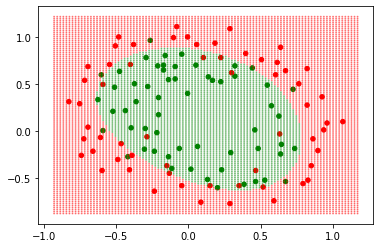


Best accuracy score for geyser.csv is 0.9054054054054054
kernel = linear
C = 1.0


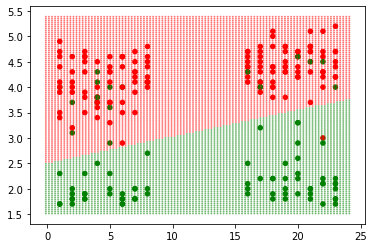

Best accuracy score for geyser.csv is 0.7612612612612613
kernel = polynomial
parameter = 2
C = 0.1


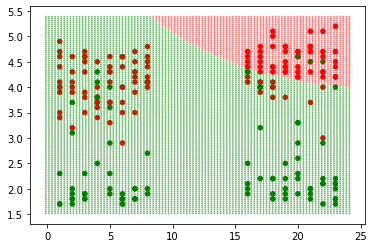

Best accuracy score for geyser.csv is 0.9054054054054054
kernel = gaussian
parameter = 1
C = 0.5


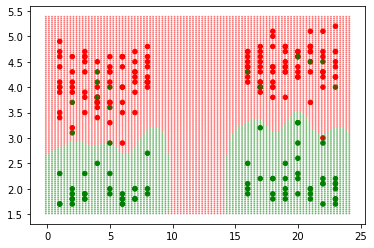

In [7]:
for filename in os.listdir('../data'):
    X, y = read_data(filename)
    class_for_kernel = get_hyperparameters(X, y)
    
    for kernel, best_scores in class_for_kernel.items():
        print('Best accuracy score for {0} is {1}'.format(filename, best_scores[0]))
        draw_graphics(X, y, best_scores[1], kernel)